In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [84]:
houses = pd.read_csv('Casas_venezuela.csv')
apartments = pd.read_csv('Departamentos_venezuela.csv')

In [30]:
def graph_categorical_relations(df, features):
    for col in features:
        fig = plt.figure(figsize=(9,6))
        ax = fig.gca()

        grouped = df.groupby(col)
        df2 = pd.DataFrame({col:vals['Precio'] for col,vals in grouped})
        medians = df2.median()
        medians.sort_values(ascending=True, inplace=True)
        df2 = df2[medians.index]

        df2.boxplot(ax=ax)
        ax.set_ylabel('Precio')
        ax.get_yaxis().set_major_formatter(lambda x, pos: f'{x:.0f}')

        if len(ax.get_xticklabels()) > 10 and any([len(str(label.get_text())) >= 5 for label in ax.get_xticklabels()]):
            ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
        elif len(ax.get_xticklabels()) > 5 and any([len(str(label.get_text())) >= 5 for label in ax.get_xticklabels()]):
            ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)

        ax.set_title('Precio en función de ' + col)
    plt.show()

In [39]:
from scipy.stats import linregress

In [40]:
def graph_numeric_relations(df, features):
    for col in features:
        fig = plt.figure(figsize=(9,6))
        ax = fig.gca()

        feature = df[col]
        df_filtered_for_outliers = df[(feature < feature.quantile(q=0.95)) & (feature > feature.quantile(q=0.01))]

        try:
            feature = df_filtered_for_outliers[col].astype(int)
            label = df_filtered_for_outliers['Precio']
        except pd.errors.IntCastingNaNError:
            feature = df_filtered_for_outliers[ df_filtered_for_outliers[col].notnull() ][col]
            label = df_filtered_for_outliers[ df_filtered_for_outliers[col].notnull() ]['Precio']

        corr = feature.corr(label)

        plt.scatter(x=feature, y=label)

        lin_reg = linregress(x=feature, y=label)
        line = [ lin_reg.slope * xi + lin_reg.intercept for xi in feature ]
        ax.plot(feature, line, color='red')

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.05, 0.95, f'Correlación: {corr}\n'+r'$R^{2}$'+f': {lin_reg.rvalue**2:.4f}', transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)

        ax.set_xlabel(col)
        ax.set_ylabel('Precio')
        ax.ticklabel_format(style='plain')
        ax.set_title(f'Precio en función de {col}')
    plt.show()

# Casas

In [34]:
houses.head()

,Precio,Codígo RAH,Tipo de Propiedad,Estilo,Área Privada,Terreno,Estado Del Inmueble,Dormitorios,Total Baños,Baños Completos,Tipo De Estacionamiento,Puestos De Estacionamiento,Amoblado,Dormitorio De Servicio,Calle,País,Estado,Ciudad,Urbanización,Medios Baños
0,498000,VE 23-26224,Casa,1 Nivel,948,948,Usado,5,8,8,Cubierto,10.0,Si,Si,Publica,Venezuela,Distrito Metropolitano,Caracas,Lomas del Club Hipico,0.0
1,240000,VE 23-26220,Casa,Multipes Niveles,307,704,Usado,5,6,5,Descubierto,4.0,No,Si,Cerrada con Vigilancia,Venezuela,Distrito Metropolitano,Caracas,El Marques,1.0
2,580000,VE 23-26215,Casa,1 Nivel,380,1251,Usado,5,6,5,Cubierto,5.0,No,Si,Cerrada con Vigilancia,Venezuela,Distrito Metropolitano,Caracas,Prados del Este,1.0
3,380000,VE 23-26209,Casa,Duplex,580,504,Usado,4,5,4,Cubierto,3.0,No,Si,Cerrada con Vigilancia,Venezuela,Distrito Metropolitano,Caracas,Sorocaima,1.0
4,270000,VE 23-26196,Casa,Multipes Niveles,400,617,Usado,4,3,3,Cubierto,5.0,No,Si,Cerrada con Vigilancia,Venezuela,Distrito Metropolitano,Caracas,Lomas del Halcon,0.0


In [47]:
house_numeric_features = ['Área Privada', 'Terreno']
houses_ordinal_features = ['Dormitorios', 'Total Baños', 'Puestos De Estacionamiento']
houses_categorical_features = ['Estilo', 'Estado Del Inmueble', 'Tipo De Estacionamiento', 'Calle', 'Ciudad']

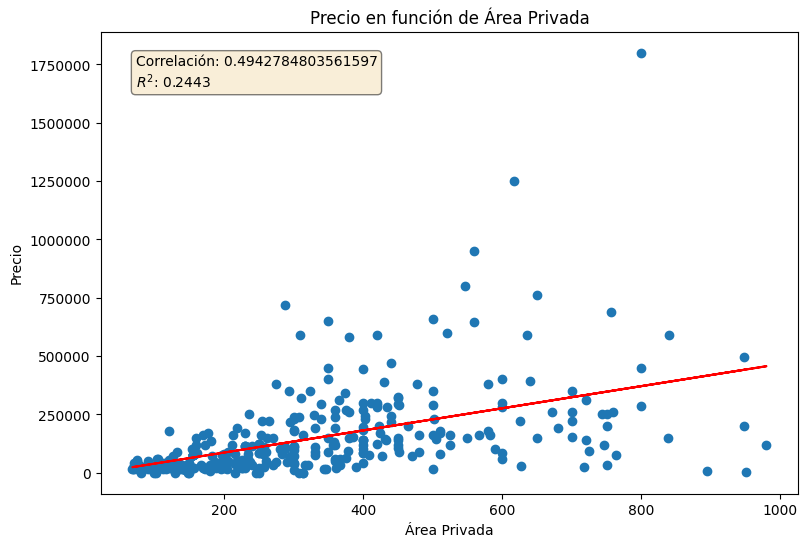

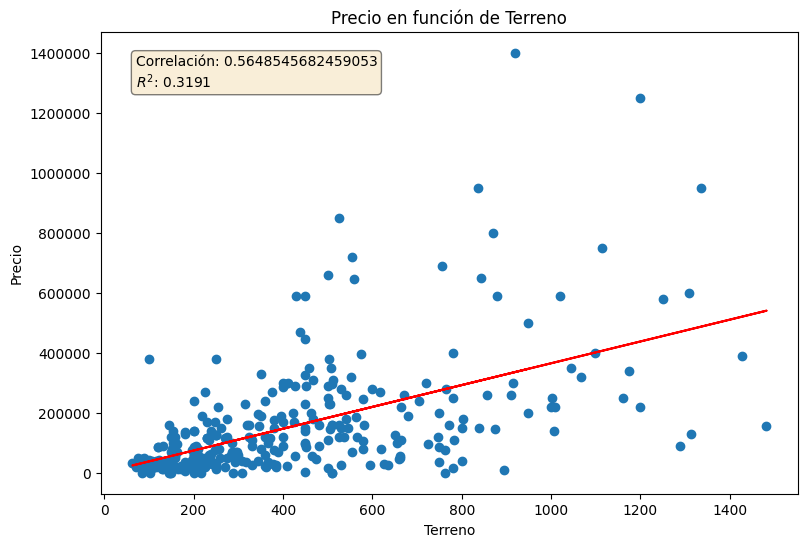

In [41]:
graph_numeric_relations(houses, house_numeric_features)

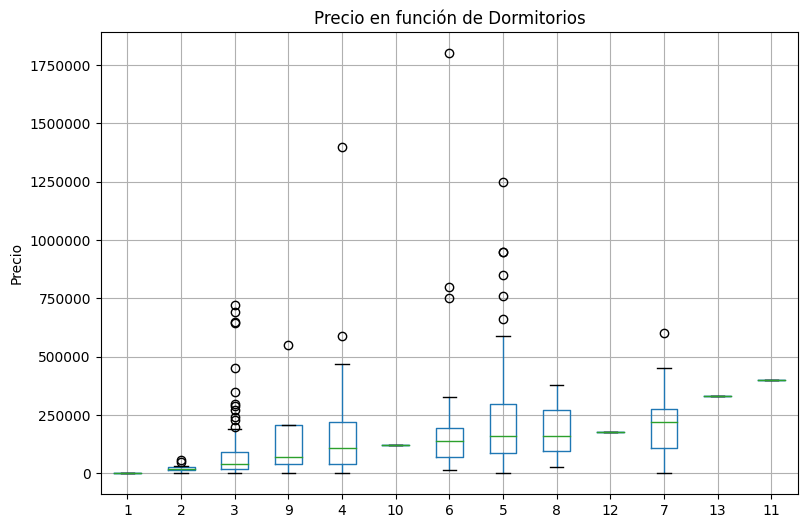

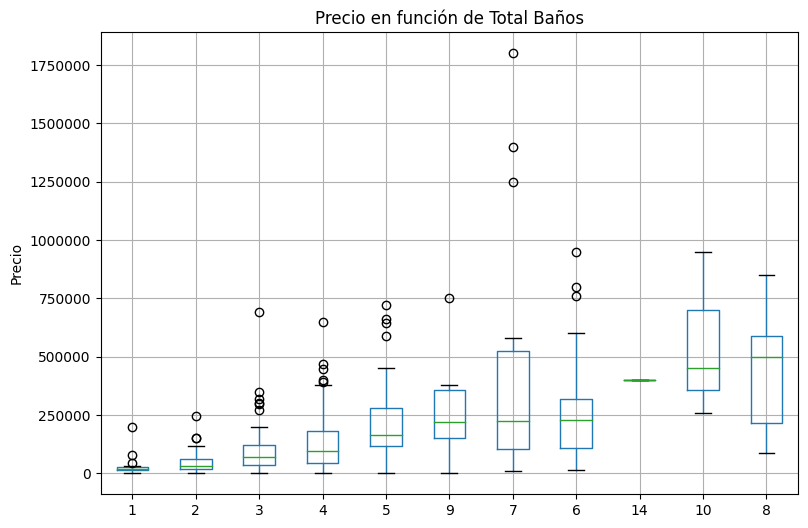

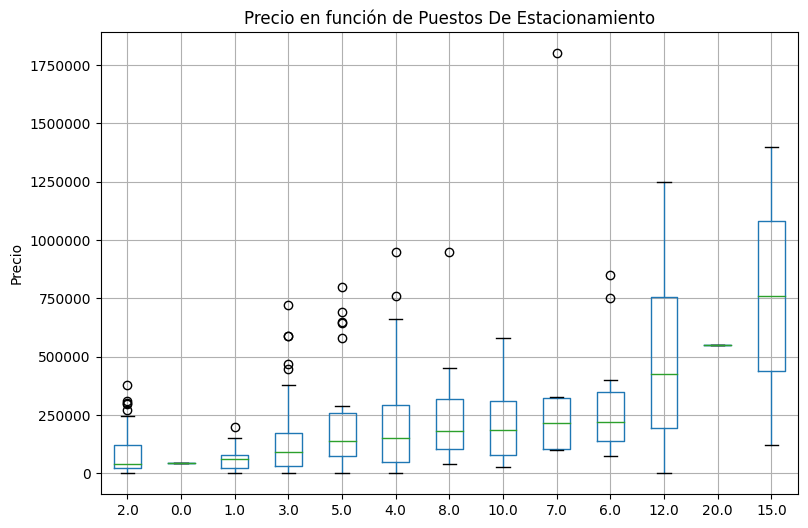

In [42]:
graph_categorical_relations(houses, houses_ordinal_features)

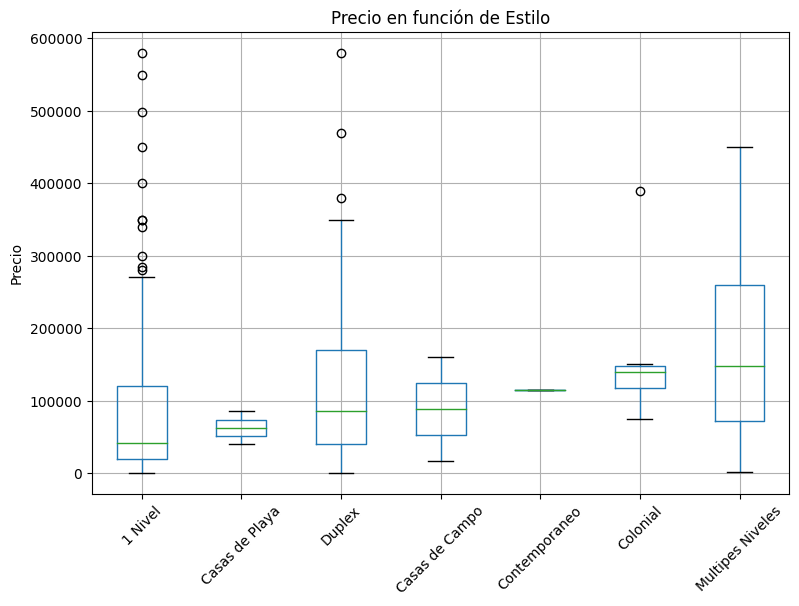

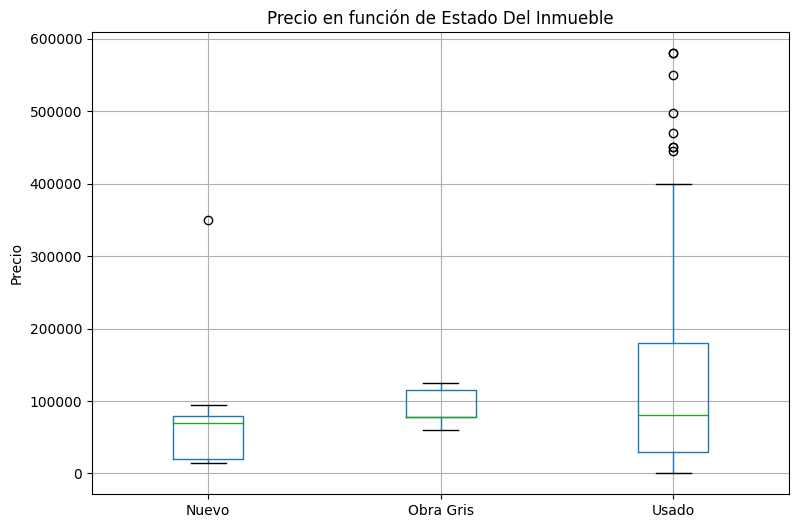

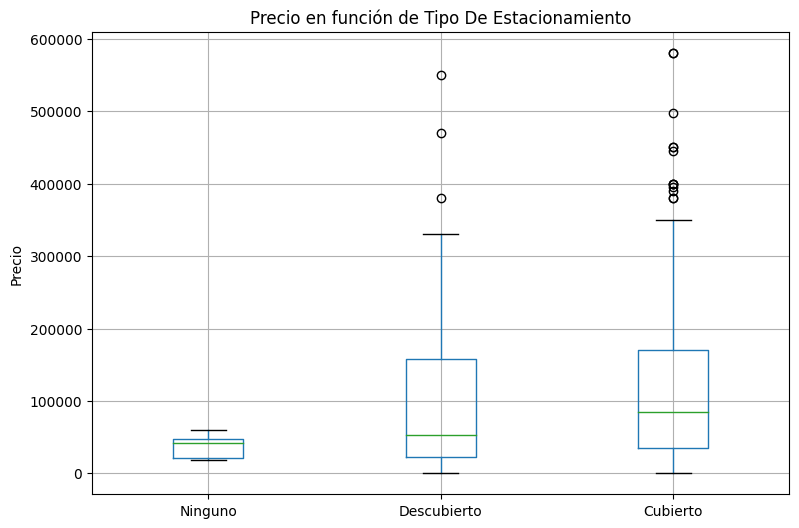

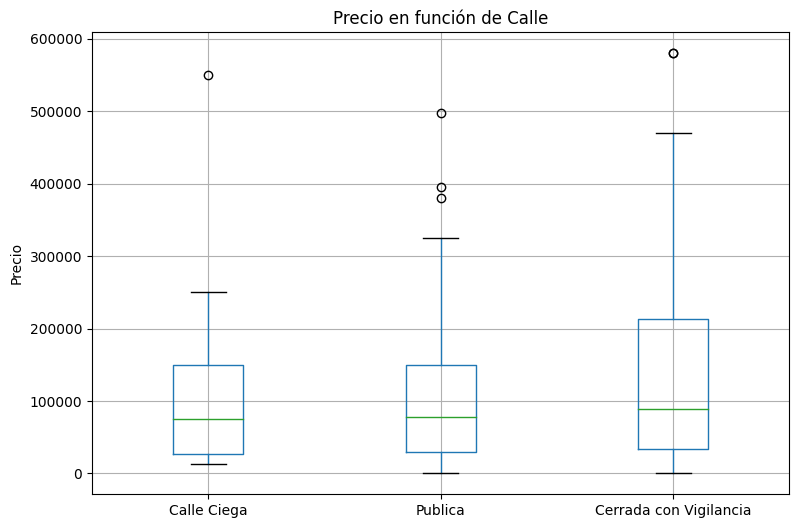

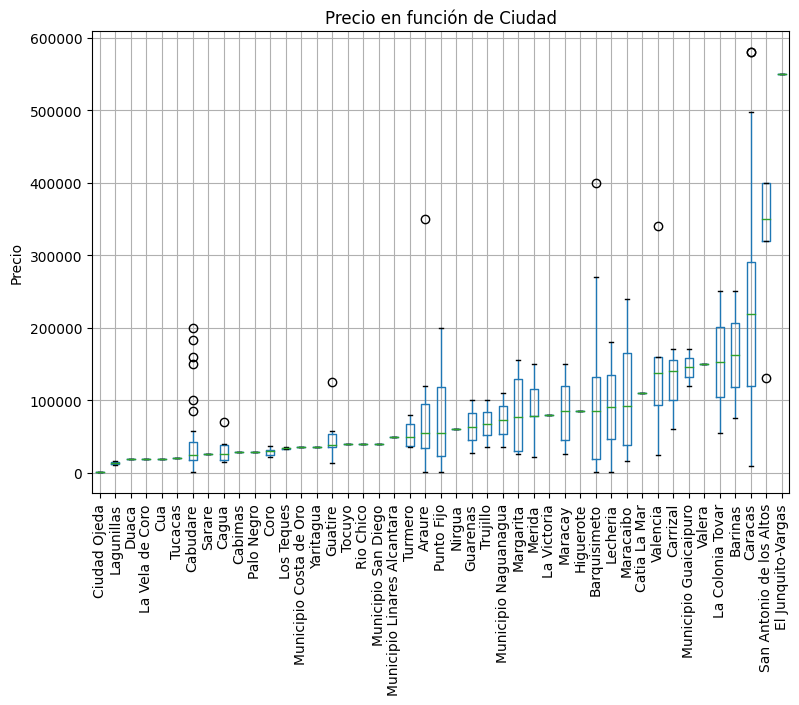

In [48]:
graph_categorical_relations(houses[houses['Precio'] < houses['Precio'].quantile(q=0.95)], houses_categorical_features)

Para las casas, el estado del inmueble y calle no parecen tener mucho efecto en el precio de la misma, por lo tanto no van a ser consideradas features para el entrenamiento de los modelos.

In [49]:
houses_categorical_features = [cat for cat in houses_categorical_features if cat not in ['Estado Del Inmueble', 'Calle']]

In [50]:
houses_categorical_features

['Estilo', 'Tipo De Estacionamiento', 'Ciudad']

## Preprocesamiento

In [85]:
houses['Puestos De Estacionamiento'].isnull().sum()

54

In [86]:
houses[(houses['Puestos De Estacionamiento'].isnull()) & (houses['Tipo De Estacionamiento'] != "Ninguno")].head()

,Precio,Codígo RAH,Tipo de Propiedad,Estilo,Área Privada,Terreno,Estado Del Inmueble,Dormitorios,Total Baños,Baños Completos,Tipo De Estacionamiento,Puestos De Estacionamiento,Amoblado,Dormitorio De Servicio,Calle,País,Estado,Ciudad,Urbanización,Medios Baños
9,14200,VE 23-26187,Casa,1 Nivel,68,130,Usado,3,2,2,Cubierto,NaN,No,No,Cerrada con Vigilancia,Venezuela,Lara,Cabudare,La Mora,0.0
10,230000,VE 23-26179,Casa,Duplex,340,450,Usado,5,6,6,Cubierto,NaN,Si,Si,Publica,Venezuela,Lara,Barquisimeto,Del Este,0.0
28,170000,VE 23-26106,Casa,Multipes Niveles,230,230,Usado,3,4,4,Cubierto,NaN,No,No,Publica,Venezuela,Miranda,Carrizal,Municipio Carrizal,0.0
29,183000,VE 23-26102,Casa,1 Nivel,300,2041,Usado,4,4,4,Cubierto,NaN,Si,No,Cerrada con Vigilancia,Venezuela,Lara,Cabudare,Tarabana,0.0
30,180000,VE 23-26100,Casa,Multipes Niveles,300,542,Usado,4,4,3,Descubierto,NaN,Parcialmente,Si,Cerrada con Vigilancia,Venezuela,Distrito Metropolitano,Caracas,La Trinidad,1.0


In [87]:
#
houses[(houses['Puestos De Estacionamiento'].isnull()) & (houses['Tipo De Estacionamiento'] != "Ninguno")]['Puestos De Estacionamiento'].isnull().sum()

49

In [88]:
houses[(houses['Puestos De Estacionamiento'].isnull()) & (houses['Tipo De Estacionamiento'] == "Ninguno")]['Puestos De Estacionamiento'].isnull().sum()

5

In [89]:
mask_no_parking_and_null = (houses['Puestos De Estacionamiento'].isnull()) & (houses['Tipo De Estacionamiento'] == "Ninguno")
houses.loc[mask_no_parking_and_null, 'Puestos De Estacionamiento'] = houses.loc[mask_no_parking_and_null, 'Puestos De Estacionamiento'].fillna(0)

In [92]:
mask_parking_but_null = (houses['Puestos De Estacionamiento'].isnull()) & (houses['Tipo De Estacionamiento'] != "Ninguno")
houses.loc[mask_parking_but_null, 'Puestos De Estacionamiento'] = houses.loc[mask_parking_but_null, 'Puestos De Estacionamiento'].fillna(1)

In [93]:
houses['Puestos De Estacionamiento'].isnull().sum()

0

In [51]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [94]:
# Estandarizacion de columnas numericas
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encoding para columnas categoricas
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combinando preprocesadores
preprocessor = ColumnTransformer(transformers=
                                 [('num', numeric_transformer, house_numeric_features),('cat', categorical_transformer, houses_categorical_features)])